In [57]:
from music21 import *
from IPython.display import Image


def music(notes: str, midi: bool = False):
    s = stream.Score()
    part = stream.Part()

    # get info
    info_start = 5

    for i in range(info_start, len(notes)):
        if notes[i : i + 5] == "INFO ":
            info_end = i

    info = list(filter(lambda x: len(x) > 0, notes[info_start:info_end].split(" ")))

    # set clef
    if info[0].lower() == "treble":
        s.append(instrument.AcousticGuitar())
        part.append(clef.TrebleClef())
    elif info[0].lower() == "bass":
        part.append(clef.BassClef())
    elif info[0].lower() == "guitar":
        part.append(clef.Treble8vbClef())

    # set key
    keys = [
        ["cb", -7],
        ["gb", -6],
        ["db", -5],
        ["ab", -4],
        ["eb", -3],
        ["bb", -2],
        ["f", -1],
        ["c", 0],
        ["g", 1],
        ["d", 2],
        ["a", 3],
        ["e", 4],
        ["b", 5],
        ["f#", 6],
        ["c#", 7],
    ]
    for k in keys:
        if info[1].lower() == k[0]:
            part.append(key.KeySignature(k[1]))

    # set time signature
    part.append(meter.TimeSignature(info[2]))

    # add notes
    notes = notes[info_end + 5 :].split(" ")
    add_notes = []
    for n in notes:
        # add chord name
        if n[0] == "!":
            add_notes.append(harmony.ChordSymbol(n[1:]))
        # start next measure on a new line
        elif n == "^":
            add_notes.append(layout.SystemLayout(isNew=True))
        else:
            # set variables
            is_chord, is_tie, is_col, lyric = False, "none", "", ""
            # if the note is a chord
            if "(" in n:
                is_chord = True
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[:lyric_start - 1]
                note_name = n.replace("(", "").replace(")", "").split(",")
                if "t" in note_name[-1]:
                    note_length = note_name[-1][-2:]
                    note_name[-1] = note_name[-1][:-2]
                else:
                    note_length = note_name[-1][-1]
                    note_name[-1] = note_name[-1][:-1]
            else:
                if "{" in n:
                    is_tie = "start"
                if "}" in n:
                    is_tie = "stop"
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[:lyric_start - 1]
                if n[-1] == "t":
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-2].replace("{", "").replace("}", "")
                    note_length = n[-2:]
                else:
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-1].replace("{", "").replace("}", "")
                    note_length = n[-1:]
            lengths = [["w", 4], ["h", 2], ["d", 3], ["q", 1], ["u", 1.5], ["e", 0.5], ["s", 0.25]]
            for l in lengths:
                if isinstance(note_length, str):
                    if l[0] in note_length:
                        if "t" in note_length:
                            note_length = l[1] * 0.333333333
                        else:
                            note_length = l[1]
            if is_tie == "none":
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, lyric])
                    else:
                        add_notes.append([note_name, note_length])
                else:
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_col, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col])
            else:
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_tie, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col, is_tie])
                else:
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_tie, is_col, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_tie, is_col])

    for n in add_notes:
        if isinstance(n, list):
            if isinstance(n[0], list):
                if len(n) == 3:
                    add_n = chord.Chord(n[0], quarterLength=n[1])
                    if "-" in n[2]:
                        texp = expressions.TextExpression(n[2].replace("-", " "))
                    else:
                        texp = expressions.TextExpression(n[2])
                    texp.style.fontSize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                else:
                    add_n = chord.Chord(n[0], quarterLength=n[1])
            else:
                if n[0].lower() == "r":
                    add_n = note.Rest(quarterLength=n[1])
                elif n[0] in ["slash", "s"]:
                    add_n = note.Unpitched()
                    add_n.notehead = "slash"
                    add_n.stemDirection = "noStem"
                    add_n.volume.velocity = 0
                else:
                    add_n = note.Note(n[0], quarterLength=n[1])
            if len(n) == 3:
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                elif n[2] not in ["#06538a", "#8a062d"]:
                    texp = expressions.TextExpression(n[2].replace("-", " "))
                    texp.style.fontsize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                else:
                    add_n.style.color = n[2]
            if len(n) == 4:
                # [note_name, note_length, is_col, lyric]
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                else:
                    add_n.style.color = n[2]
                if n[3] not in ["#06538a", "#8a062d"]:
                    texp = expressions.TextExpression(n[3].replace("-", " "))
                    texp.style.fontSize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                else:
                    add_n.style.color = n[3]
            elif len(n) == 5:
                add_n.tie = tie.Tie(n[2])
                add_n.style.color = n[3]
                texp = expressions.TextExpression(n[4].replace("-", ""))
                texp.style.fontSize = 10
                texp.style.fontFamily = "Segoe UI"
                texp.placement = "below"
                part.append(texp)
            part.append(add_n)
        else:
            part.append(n)

    if info[0].lower() == "guitar":
        part.makeNotation()

    s.append(part)

    if info[0].lower() == "guitar":
        s.makeNotation()

    swung_part = stream.Part()

    if midi:
        step = 0.0
        for item in part:
            if isinstance(item, note.Note) or isinstance(item, note.Rest):
                if str(step)[-1] == "9":
                    step = float(round(step))
                elif str(step)[-1] == "2":
                    step = float(round(step))
                if isinstance(item, note.Note):
                    new_note = note.Note(item.pitch)
                    if item.tie:
                        if "start" in str(item.tie):
                            new_note.tie = tie.Tie("start")
                        if "stop" in str(item.tie):
                            new_note.tie = tie.Tie("stop")
                        if "continue" in str(item.tie):
                            new_note.tie = tie.Tie("continue")
                else:
                    new_note = note.Rest()
                if str(step)[-2:] == ".0":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333 * 2
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + (0.333333333 * 2)
                    elif str(item.quarterLength) == "1/3":
                        new_note.quarterLength = 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                elif str(step)[-2:] == ".5":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                if str(item.quarterLength) == "1/3":
                    new_note.quarterLength = 0.333333333
                swung_part.append(new_note)
                step += item.quarterLength
            else:
                swung_part.append(item)
        swung_s = stream.Stream()
        guitar = instrument.Guitar()
        swung_s.append(guitar)
        swung_s.append(swung_part)
        return swung_s.show("midi")
    else:
        return Image(filename=s.write("musicxml.png"))

# Music Theory for Guitar Players

by **Chris Wright**

fig. 1


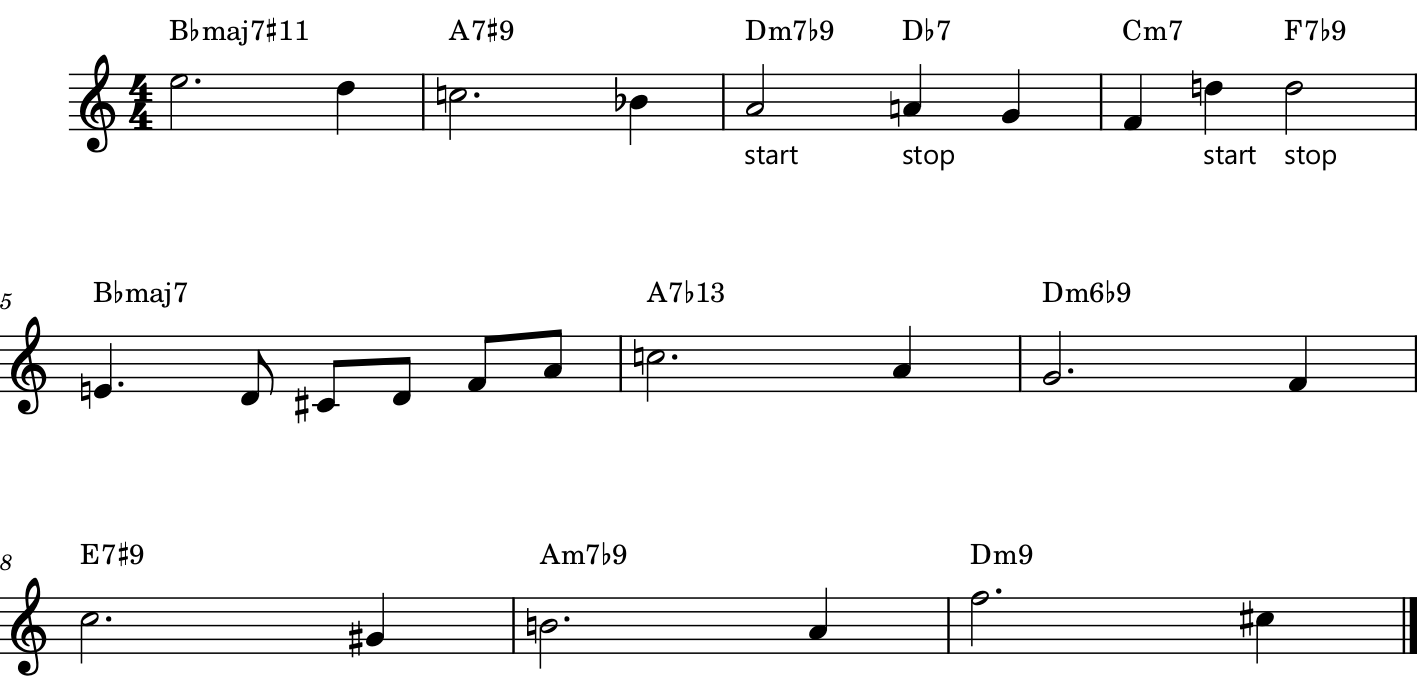

In [2]:
notes = "INFO treble c 4/4 INFO !b-maj7#11 e5d d5q !a7#9 c5d b-4q !dm7b9 a4{h !d-7 a4}q g4q !cm7 f4q d5{q !f7b9 d5}h ^ "
notes += "!b-maj7 e4u d4e c#4e d4e f4e a4e !a7b13 c5d a4q !dm6b9 g4d f4q ^ "
notes += "!e7#9 c5d g#4q !am7b9 b4d a4q !dm9 f5d c#5q"

print("fig. 1")
music(notes, True)
music(notes)

This book will be constructed over 5 parts:

> 1. **Where Are Guitar Notes In Sheet Music?** First we'll break down the names of guitar notes, then we'll see where each note is on a sheet of music.
> 2. **What Are Keys And Time Signatures?** In this section, we'll go over keys in music (and how they're easy to transpose to different keys) and time signatures (with some example songs in their signature).
> 3. **How Do Scales Work?** I'm sure you know that minor and major scales sound different, but why is that and how do the minor and major scales relate? You'll also learn about two other minor scales (which can have a nice sound) and you'll be briefed on what modes are (even though, if you're not too deep into music theory, they're not wildly important).
> 4. **How Are Chords Constructed?** Here, you'll learn what makes up a chord, how you can voice your chords, and you'll learn about the different symbols on music sheets that specify what chord to play.
> 5. **How Do I Come Up With Melodies?** Let's apply what we've learned to make a quick song.

Hopefully, by the end of this book, you'll be able to pick up a lead sheet for a song and play it easily.

Let's get started!

## Where Are Guitar Notes In Sheet Music?

### Guitar Strings to Sheet Music

First things first. Let's find out what notes you're playing when you play your guitar.

The bottom line in the tab is the lowest string on your guitar, the low E string. The top line is the high E string. You can see this below in **fig. 2**.

fig. 2


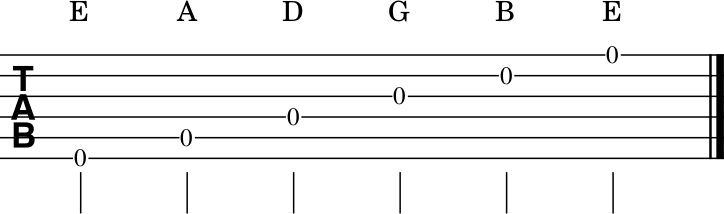

In [3]:
s = stream.Score()
p = stream.Part()
c = clef.TabClef()
l = layout.StaffLayout()
l.staffLines = 6
t = meter.TimeSignature("6/4")

p.append(t)
p.append(c)
p.append(l)

g = instrument.AcousticGuitar()
p.append(g)

en = note.Note("E2", quarterLength=1)
an = note.Note("A2", quarterLength=1)
dn = note.Note("D3", quarterLength=1)
gn = note.Note("G3", quarterLength=1)
bn = note.Note("B3", quarterLength=1)
hen = note.Note("E4", quarterLength=1)

ec = harmony.ChordSymbol("E")
ac = harmony.ChordSymbol("A")
dc = harmony.ChordSymbol("D")
gc = harmony.ChordSymbol("G")
bc = harmony.ChordSymbol("B")
hec = harmony.ChordSymbol("E")

p.append(ec)
p.append(en)
p.append(ac)
p.append(an)
p.append(dc)
p.append(dn)
p.append(gc)
p.append(gn)
p.append(bc)
p.append(bn)
p.append(hec)
p.append(hen)

s.append(p)

s.makeNotation()

print("fig. 2")
s.show()

Next, let's look at where these notes fall in sheet music in **fig. 3**.

fig. 3


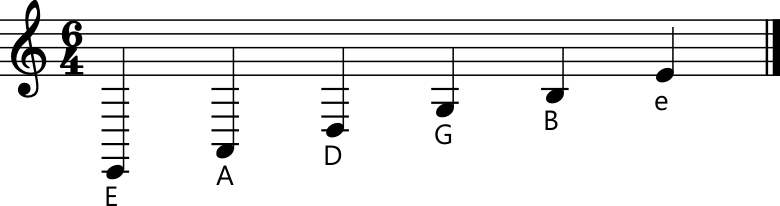

In [4]:
notes = "INFO treble c 6/4 INFO e2q[E] a2q[A] d3q[D] g3q[G] b3q[B] e4q[e]"

print("fig. 3")
music(notes, True)
music(notes)

For simplicity sake, you could just look at these notes as relating here on the sheet (**fig. 4**).

fig. 4


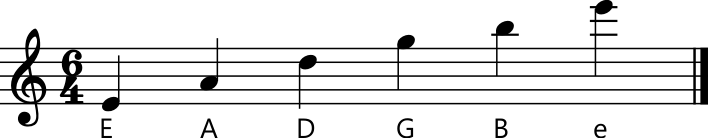

In [5]:
notes = "INFO treble c 6/4 INFO e4q[E] a4q[A] d5q[D] g5q[G] b5q[B] e6q[e]"

print("fig. 4")
music(notes, True)
music(notes)

### Guitar Notes to Sheet Music

When you play guitar, whenever you move up one fret you move up one **half-step**. So if you played a C note on your guitar and moved up one fret, you'd land on a C# note (**fig. 5**).

fig. 5


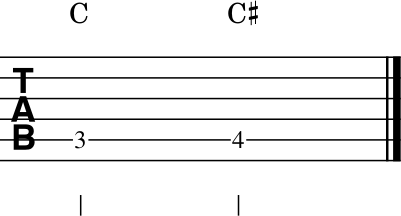

In [6]:
s = stream.Score()
p = stream.Part()
c = clef.TabClef()
l = layout.StaffLayout()
l.staffLines = 6
t = meter.TimeSignature("6/4")

p.append(t)
p.append(c)
p.append(l)

g = instrument.AcousticGuitar()
p.append(g)

cn = note.Note("C3", quarterLength=2)
csn = note.Note("C#3", quarterLength=2)

cc = harmony.ChordSymbol("C")
csc = harmony.ChordSymbol("C#")

p.append(cc)
p.append(cn)
p.append(csc)
p.append(csn)

s.append(p)

s.makeNotation()

print("fig. 5")
s.show()

Here's an equivalent in sheet music (**fig. 6**).

fig. 6


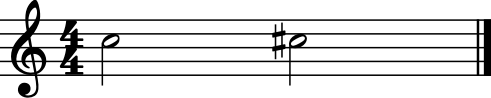

In [7]:
notes = "INFO treble c 4/4 INFO c5h c#5h"

print("fig. 6")
music(notes)

### Notes From C to C in Sheet Music

Below, I'll list out each note in sheet music (**fig. 7**). Every note listed in red is the same note; for example, a C♯ is the same as a D♭.

fig. 7


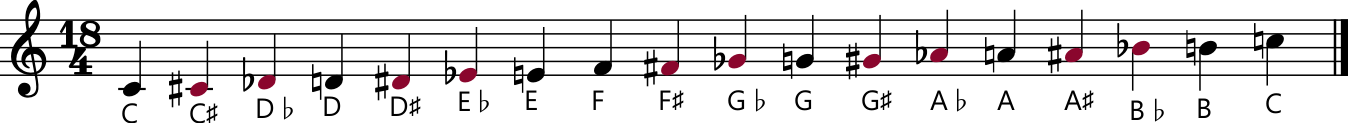

In [8]:
notes = "INFO treble c 18/4 INFO c4q[C] Rc#4q[C♯] Rd-4q[D♭] d4q[D] Rd#4q[D♯] Re-4q[E♭] e4q[E] f4q[F] Rf#4q[F♯] Rg-4q[G♭] g4q[G] Rg#4q[G♯] Ra-4q[A♭] a4q[A] Ra#4q[A♯] Rb-4q[B♭] b4q[B] c5q[C]"

print("fig. 7")
music(notes)

Sometimes you'll see an E♯ note (which is just an F), an F♭ (which is an E) note, a B♯ (which is a C), or a C♭ (which is a B). If you were to move up from a C note to a D note, this is a *full-step*, you're essentially moving up two frets (unless you're looking at E to F or B to C).

### Guitar Chords to Sheet Music

Next, let's look at how a guitar chord translates to sheet music. **fig. 8** and **fig. 9** are essentially the same thing. The first chord in **fig. 9** is exactly how you'd play it on guitar, the second chord is the triad of the C chord, without duplicate notes, how you'd traditionally see it in sheet music.

fig. 8


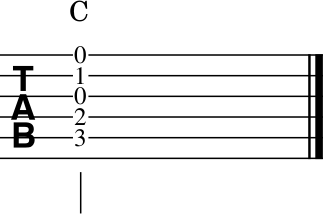

In [9]:
s = stream.Score()
p = stream.Part()
c = clef.TabClef()
l = layout.StaffLayout()
l.staffLines = 6
t = meter.TimeSignature("6/4")

p.append(t)
p.append(c)
p.append(l)

g = instrument.AcousticGuitar()
p.append(g)

cc = chord.Chord(["C3", "E3", "G3", "C4", "E4"])
cn = harmony.ChordSymbol("C")

p.append(cn)
p.append(cc)

s.append(p)

s.makeNotation()

print("fig. 8")
s.show()

fig. 9


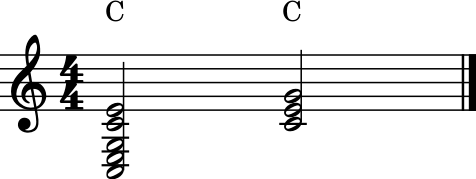

In [10]:
notes = "INFO treble c 4/4 INFO !c (c3,e3,g3,c4,e4)h !c (c4,e4,g4)h"

print("fig. 9")
music(notes)

### Summary

So (hopefully) now you can see how notes and chords transfer to sheet music. Next, let's look more into detail about sheet music notation.

## What Are Keys And Time Signatures?

Before we get into keys and time signatures, let's quickly go over the basics of a sheet (**fig. 10**).

fig. 10


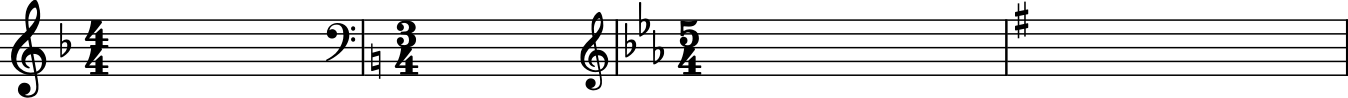

In [13]:
s = stream.Score()
p = stream.Part()
m = stream.Measure()
m2 = stream.Measure()
m3 = stream.Measure()
m4 = stream.Measure()

c = clef.TrebleClef()
c2 = clef.BassClef()

t = meter.TimeSignature("4/4")
t2 = meter.TimeSignature("3/4")
t3 = meter.TimeSignature("5/4")

k = key.KeySignature(-1)
k2 = key.KeySignature(0)
k3 = key.KeySignature(-3)
k4 = key.KeySignature(1)

m.append(c)
m.append(t)
m.append(k)

m2.append(c2)
m2.append(t2)
m2.append(k2)

m3.append(c)
m3.append(t3)
m3.append(k3)

m4.append(k4)

p.append(m)
p.append(m2)
p.append(m3)
p.append(m4)
s.append(p)

print("fig. 10")
s.show()

There are four things to understand here:

**Staff Lines** are the five horizontal lines and spaces between the five horizontal lines which hold our notes. Each space between and line represents a white key on a keyboard.

**Clefs.** The first item on each staff is the clef. We have three clefs on the example in **fig. 10**: *Treble clef* (what you'll mostly see) and *bass clef* (this is lower and the notes are different but we won't really be going over this, it's mostly for bass players and piano players).

**Key Signatures** are the next thing you'll see on the staff. 

In the example above the first key signature is one flat which lies on the B note. This just means that every B note you play will be flat unless otherwise marked.

The second key is C, typically the key of C won't have any key signature on your score because it's the *default* key. It's marked here with a natural symbol (♮) because it's telling us that instead of playing every B note flat, we'll play it natural. You'll also notice it's lower than it was before, this is because the note falls into a different place on the *bass clef*.

The third key holds 3 flats, so you'd play every B, E, and A note flat.

The fourth key holds 1 sharp, so you'd play every F note sharp.

> *Quick tip!* 
> 
> It's easy to figure out what key you're in quickly by using the following method:
>
> No key signature markings is always *C major*.
>
> One flat is the key of *F*.
>
> If there are any sharps in the key signature, the key is always the note after the last sharp. So in the example above, the key on the last measure is *G* because there's one sharp.
>
> If there are two or more flats in the key signature, the key is always the flat before last. So in the example above, the key on the third measure is *E♭*.

**Time Signatures** are the numbers after the key signature on the staff. The top number stands for how many notes in a measure and the bottom number is how long the note is. So in the example above, the first measure would hold four quarter notes, the second would hold three, and the third five.

## How Do Scales Work?

Scales are important because they tell us which notes to play in our song. We'll be going over four scales here: **Major**, **(Natural) Minor**, **Harmonic Minor**, and **Melodic Minor**.

Let's look over how each one is constructed.

### Major Scale

Here's how the key of C major is constructed (**fig. 11**):

fig. 11


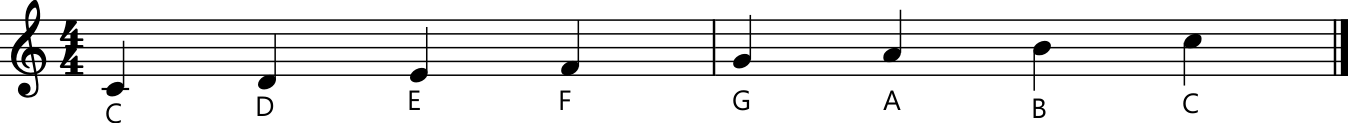

In [16]:
notes = "INFO treble c 4/4 INFO c4q[C] d4q[D] e4q[E] f4q[F] g4q[G] a4q[A] b4q[B] c5q[C]"

print("fig. 11")
music(notes, True)
music(notes)

Every major scale is built using the following pattern:

> Key note - Whole step (two frets) - Whole step - Half step (1 fret) - Whole step - Whole Step - Whole Step - Half Step

We can easily translate this to any key, let's look at the same key in B♭ (**fig. 12**).

fig. 12


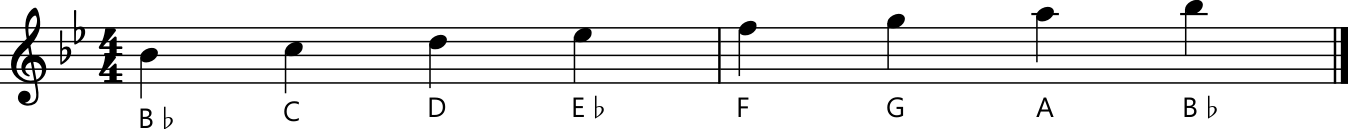

In [17]:
notes = "INFO treble bb 4/4 INFO b-4q[B♭] c5q[C] d5q[D] e-5q[E♭] f5q[F] g5q[G] a5q[A] b-5q[B♭]"

print("fig. 12")
music(notes, True)
music(notes)

### (Natural) Minor Scale

The first of the three minor scales is the *Natural Minor*, usually just called *Minor* because it's more-or-less the default. Here's how it's built:

> Key note - Whole step - Half step - Whole step - Whole step - Half step - Whole step - Whole step

Its construction is shown as A minor in **fig. 13**.

fig. 13


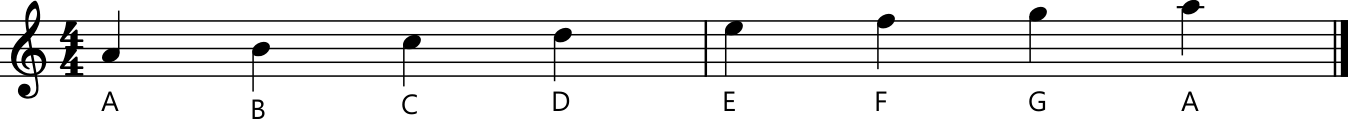

In [18]:
notes = "INFO treble c 4/4 INFO a4q[A] b4q[B] c5q[C] d5q[D] e5q[E] f5q[F] g5q[G] a5q[A]"

print("fig. 13")
music(notes, True)
music(notes)

You may notice that the key signature is still C major. This is because the Major scale and the (Natural) Minor scale are related one-to-one; the only difference is where you start. If you're in any Major scale (for example, E♭ major), change your starting (root) note three half-steps below (continuing the example, you'd be in C minor).

### Harmonic Minor Scale

This scale is similar to the *(Natural) Minor* scale, except you raise (move up one half step) the note before you reach the octave over the root.

> Key note - Whole step - Half step - Whole step - Whole step - Half step - Whole step + Half step - Half step

This scale has a different sound and isn't as common but you can find interesting uses for it in different styles. For example, [Paint It Black by The Rolling Stones](https://www.youtube.com/watch?v=O4irXQhgMqg) is in harmonic minor. **fig.14** shows how the scale of D Harmonic Minor is constructed.

fig. 14


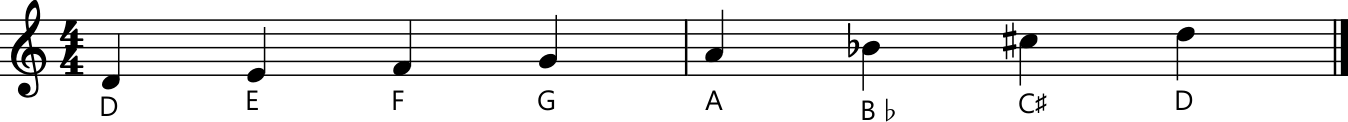

In [19]:
notes = "INFO treble c 4/4 INFO d4q[D] e4q[E] f4q[F] g4q[G] a4q[A] b-4q[B♭] c#5q[C♯] d5q[D]"

print("fig. 14")
music(notes, True)
music(notes)

### Melodic Minor Scale

The last scale we'll go over is the *Melodic Minor Scale*. This scale also has its own unique quality.It's constructed like so:

> Key note - Whole step - Half step - Whole step - Whole step - Whole step - Whole Step - Half step

An example of the *Melodic Minor Scale* in action is [Love Buzz by Nirvana](https://www.youtube.com/watch?v=Xm0qjrceeYE).

Here's how it sounds (**fig. 15**):

fig. 15


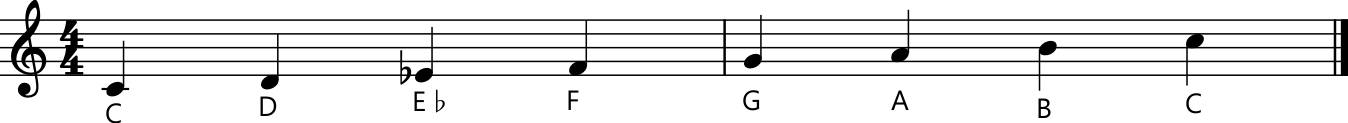

In [22]:
notes = "INFO treble c 4/4 INFO c4q[C] d4q[D] e-4q[E♭] f4q[F] g4q[G] a4q[A] b4q[B] c5q[C]"

print("fig. 15")
music(notes, True)
music(notes)

### Intervals, Chord Tones, Chord Tensions

Let's bring some context to scales before we move onto chords. It'll help a lot because you'll see how intervals of a scale play into chord construction.

We'll just focus on the *Major Scale* for this section, let's first look at the C major scale (**fig. 16**).

fig. 16


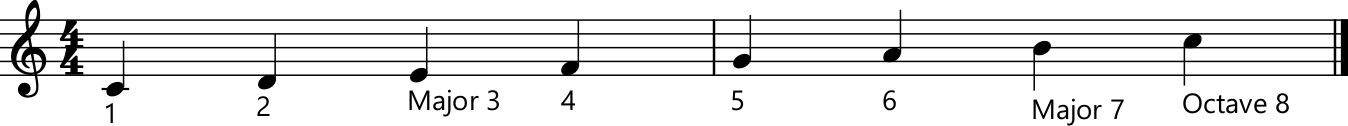

In [24]:
notes = "INFO treble c 4/4 INFO c4q[1] d4q[2] e4q[Major-3] f4q[4] g4q[5] a4q[6] b4q[Major-7] c5q[Octave-8]"

print("fig. 16")
music(notes, True)
music(notes)

You can see above in **fig. 16** the interval for each note in the scale, you basically just count up from 1 - 8. You can extend further with 9 (a D note), 10, 11, 12, 13, 14, 15, 16, etc. However, you'll usually just find that in the chords you use with the extensions (9+), you'll mainly just use the 9, 11, and 13.

Let's look at each one and see how it sounds. It's often helpful to do *interval ear training*, there are apps for it but the best one I use is on the site [musictheory.net](https://www.musictheory.net/exercises/interval). Besides this interval training tool, they have a ton of learning resources that are interactive and will teach you music theory very quickly and easily.

Let's look at the intervals (**fig. 17**).

fig. 17


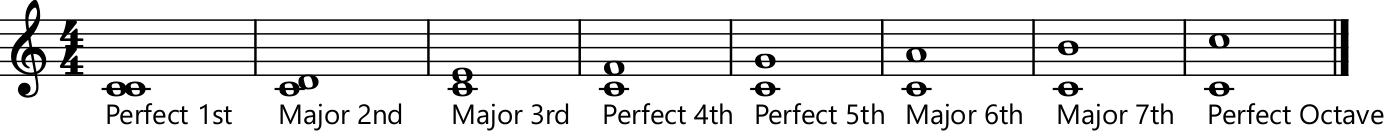

In [39]:
notes = "INFO treble c 4/4 INFO (c4,c4)w[Perfect-1st] (c4,d4)w[Major-2nd] (c4,e4)w[Major-3rd] (c4,f4)w[Perfect-4th] (c4,g4)w[Perfect-5th] (c4,a4)w[Major-6th] (c4,b4)w[Major-7th] (c4,c5)w[Perfect-Octave]"

print("fig. 17")
music(notes, True)
music(notes)

It's not too difficult to recognize where the 4th, 5th, and Major 7th are on the scale.

Let's take a quick look at the intervals of a minor scale (**fig. 18**).

fig. 18


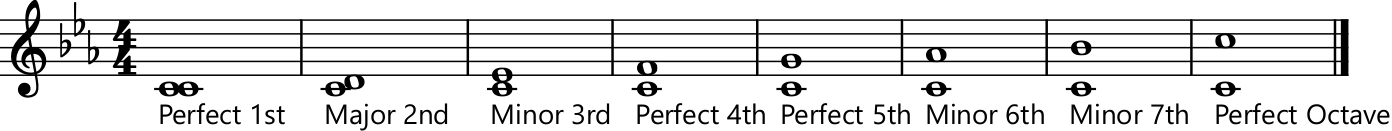

In [42]:
notes = "INFO treble eb 4/4 INFO (c4,c4)w[Perfect-1st] (c4,d4)w[Major-2nd] (c4,e-4)w[Minor-3rd] (c4,f4)w[Perfect-4th] (c4,g4)w[Perfect-5th] (c4,a-4)w[Minor-6th] (c4,b-4)w[Minor-7th] (c4,c5)w[Perfect-Octave]"

print("fig. 18")
music(notes, True)
music(notes)

Okay, I think we're ready to move onto chord construction.

## How Are Chords Constructed?

Let's go back to the C chord example we looked at earlier (**fig. 19**).

fig. 19


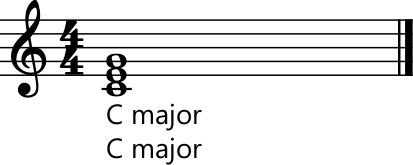

In [58]:
notes = "INFO treble c 4/4 INFO (c4,e4,g4)w[C-major]"

print("fig. 19")
music(notes)

## How Do I Come Up With Melodies?